<a href="https://colab.research.google.com/github/sid6236/Classification-of-Encrypted-Data/blob/main/AES_crypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pycryptodome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.0 MB/s eta 0:00:00


In [ ]:
pip install cipher

  Preparing metadata (setup.py) ... done
  Created wheel for cipher: filename=cipher-0.1-py3-none-any.whl size=2248 sha256=917131f6c5ba5af3ee24eaeae257b5995cc316d87c66ffd9fae9b4c0cea9c3b2
  Stored in directory: /root/.cache/pip/wheels/bb/c5/11/f5c504d02de5ce9132e0c701bb2badf060f9f73b08deb1b0d8
Successfully built cipher


In [ ]:
pip install AES

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import base64
import os
import matplotlib.pyplot as plt

In [ ]:
# Function to encrypt text using AES
def encrypt_aes(text, key, mode):
    text = str(text)  # Ensure the text is a string
    cipher = AES.new(key, mode)
    if mode == AES.MODE_ECB:
        encrypted_text = cipher.encrypt(pad(text.encode('utf-8'), AES.block_size))
    elif mode == AES.MODE_CBC:
        iv = os.urandom(AES.block_size)
        cipher = AES.new(key, mode, iv)
        encrypted_text = iv + cipher.encrypt(pad(text.encode('utf-8'), AES.block_size))
    return base64.b64encode(encrypted_text).decode('utf-8')

In [ ]:
# Load dataset
df = pd.read_csv("/content/full_data_UpTo_nov2021.csv")

# Assuming the dataset has a 'content' column containing news summaries
df['content'] = df['content'].fillna('')  # Fill NaN values with empty string
df_sample = df.sample(2000, random_state=42)  # Taking 2000 samples

# Split into two sets for ECB and CBC
df_ecb = df_sample.iloc[:1000].copy()
df_cbc = df_sample.iloc[1000:].copy()

# AES key (must be either 16, 24, or 32 bytes long)
key = os.urandom(32)

# Encrypt the text data
df_ecb['content'] = df_ecb['content'].apply(lambda x: encrypt_aes(x, key, AES.MODE_ECB))
df_cbc['content'] = df_cbc['content'].apply(lambda x: encrypt_aes(x, key, AES.MODE_CBC))

# Add mode column
df_ecb['mode'] = 'ECB'
df_cbc['mode'] = 'CBC'

<ipython-input-7-7cab5616dbc2>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/full_data_UpTo_nov2021.csv")


In [ ]:
# Combine the datasets
df_combined = pd.concat([df_ecb, df_cbc])

# Preprocess Data
X = df_combined['content']
y = df_combined['mode']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Feature Extraction for Random Forest
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

         CBC       0.65      1.00      0.79       201
         ECB       1.00      0.46      0.63       199

    accuracy                           0.73       400
   macro avg       0.83      0.73      0.71       400
weighted avg       0.82      0.73      0.71       400

Random Forest Accuracy: 0.73


In [ ]:
# Feature Extraction for LSTM
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input length
max_seq_length = 100  # This can be adjusted based on the dataset
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)

# Train LSTM
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
embedding_dim = 100

lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_dim, input_length=max_seq_length))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Convert labels to binary (0 for ECB, 1 for CBC)
y_train_binary = (y_train == 'CBC').astype(int)
y_test_binary = (y_test == 'CBC').astype(int)

lstm_model.fit(X_train_pad, y_train_binary, epochs=5, batch_size=32, validation_split=0.1)

# Evaluate LSTM
y_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")
print("LSTM Classification Report:")
print(classification_report(y_test_binary, y_pred_lstm))
print("LSTM Accuracy:", accuracy_score(y_test_binary, y_pred_lstm))

Epoch 1/5
45/45 [==============================] - 17s 301ms/step - loss: 0.6826 - accuracy: 0.5701 - val_loss: 0.6564 - val_accuracy: 0.6938
Epoch 2/5
45/45 [==============================] - 12s 277ms/step - loss: 0.5643 - accuracy: 0.7354 - val_loss: 0.5550 - val_accuracy: 0.6875
Epoch 3/5
45/45 [==============================] - 10s 228ms/step - loss: 0.3614 - accuracy: 0.8438 - val_loss: 0.5470 - val_accuracy: 0.7063
Epoch 4/5
45/45 [==============================] - 12s 270ms/step - loss: 0.2981 - accuracy: 0.8528 - val_loss: 0.5398 - val_accuracy: 0.7000
Epoch 5/5
13/13 [==============================] - 1s 32ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.49      0.64       199
           1       0.65      0.96      0.78       201

    accuracy                           0.72       400
   macro avg       0.78      0.72      0.71       400
weighted avg       0.78      0.72      0.71       400

LSTM Accuracy

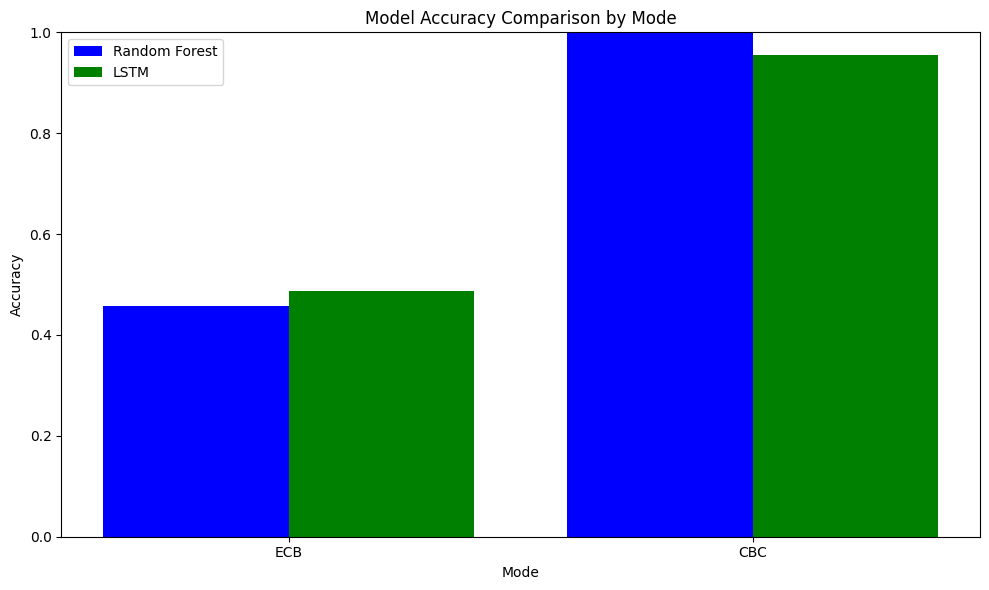

In [ ]:
# Calculate accuracy for each mode and model
rf_accuracy_ecb = accuracy_score(y_test[y_test == 'ECB'], y_pred_rf[y_test == 'ECB'])
rf_accuracy_cbc = accuracy_score(y_test[y_test == 'CBC'], y_pred_rf[y_test == 'CBC'])
lstm_accuracy_ecb = accuracy_score(y_test_binary[y_test == 'ECB'], y_pred_lstm[y_test == 'ECB'])
lstm_accuracy_cbc = accuracy_score(y_test_binary[y_test == 'CBC'], y_pred_lstm[y_test == 'CBC'])

# Compare Random Forest and LSTM accuracy for ECB and CBC
modes = ['ECB', 'CBC']
rf_accuracies = [rf_accuracy_ecb, rf_accuracy_cbc]
lstm_accuracies = [lstm_accuracy_ecb, lstm_accuracy_cbc]

x = range(len(modes))

plt.figure(figsize=(10, 6))

plt.bar(x, rf_accuracies, width=0.4, label='Random Forest', align='center', color='blue')
plt.bar([p + 0.4 for p in x], lstm_accuracies, width=0.4, label='LSTM', align='center', color='green')

plt.xlabel('Mode')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison by Mode')
plt.xticks([p + 0.2 for p in x], modes)
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()